# MNIST digit classification

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We'll train a simple CNN on the MNIST dataset by copy/pasting [this example](https://keras.io/examples/mnist_cnn/) from the Keras documentation.

In [2]:
###### from __future__ import print_function
import ethik

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.
/home/max/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/max/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/max/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/max/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Now let's predict the class probabilities for the test set.

In [20]:
y_pred = model.predict_proba(x_test)
np.save("y_pred.npy", y_pred)

Run the algorithm.

In [3]:
import numpy as np
y_pred = np.load("notebooks/y_pred.npy")

In [58]:
import ethik
explainer = ethik.ImageClassificationExplainer(n_jobs=-1)
explainer.plot_bias(x_test, y_pred)

In [59]:
from sklearn import metrics

perf = explainer.explain_performance(
    X_test=x_test,
    y_test=y_test.argmax(axis=1),
    y_pred=y_pred.argmax(axis=1),
    metric=metrics.accuracy_score
)
perf.head()

,feature,tau,value,lambda,label,bias,bias_low,bias_high,accuracy_score,accuracy_score_low,accuracy_score_high
0,"(0, 0, 0)",-1.0,0.0,0.0,0,0.098045,0.098045,0.098045,0.9914,0.9914,0.9914
1,"(0, 0, 0)",1.0,0.0,0.0,0,0.098045,0.098045,0.098045,0.9914,0.9914,0.9914
20,"(0, 1, 0)",-1.0,0.0,0.0,0,0.098045,0.098045,0.098045,0.9914,0.9914,0.9914
21,"(0, 1, 0)",1.0,0.0,0.0,0,0.098045,0.098045,0.098045,0.9914,0.9914,0.9914
40,"(0, 2, 0)",-1.0,0.0,0.0,0,0.098045,0.098045,0.098045,0.9914,0.9914,0.9914


In [68]:
explainer.plot_performance(
    X_test=x_test,
    y_test=y_test.argmax(axis=1),
    y_pred=y_pred.argmax(axis=1),
    metric=metrics.accuracy_score
)

In [69]:
explainer.plot_performance(
    X_test=x_test,
    y_test=y_test,
    y_pred=y_pred,
    metric=metrics.log_loss
)

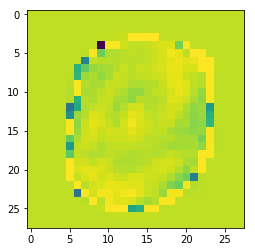

In [25]:
import matplotlib.pyplot as plt

diffs = perf.query('tau == 1')['accuracy_score'] - perf.query('tau == -1')['accuracy_score'].to_numpy()
diffs = diffs.to_numpy().reshape(explainer.img_shape)
plt.imshow(diffs)

In [29]:
diffs.max()

0.009139676203520963

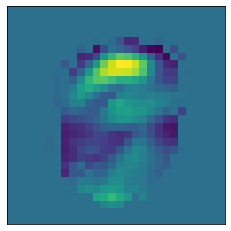

In [208]:
mask = (y_test[:, 4] == 1) | (y_test[:, 9] == 1)

ax = explainer.plot_predictions(x_test[mask], y_pred[mask, 9])

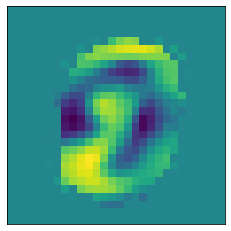

In [209]:
mask = (y_test[:, 8] == 1) | (y_test[:, 9] == 1)

ax = explainer.plot_predictions(x_test[mask], y_pred[mask, 8])

/home/max/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:424: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


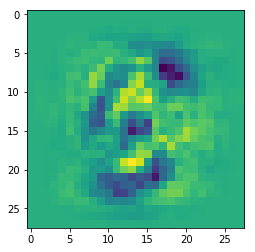

In [207]:
from sklearn import metrics

ax = explainer.plot_metric(
    images=x_test,
    y=y_test.argmax(axis=1),
    y_pred=y_pred.argmax(axis=1),
    metric=metrics.accuracy_score
)